# Hyper-parameter Investigation

Hyper-parameters to be investigated: <br>
1. Number of hidden layers <br>
2. Number of nodes per layer <br>
3. The type of activation function used in each layer <br>
4. The learning rate <br>
5. The number of epochs <br>

Baseline parameters used for the network (unless otherwise specified):
- Leaky ReLU activation function for hidden layers
- Sigmoid activation function for the output layer 
- A single training cycle consists of 200 epochs (initially had 1000 epochs but all activity rates seem to flat-line at around 150 so for the sake of saving time it's 200 now)
- Default learning rate is 0.01

## Setup

In [1]:
import time
import funcs
import network as net
import numpy as np
import pandas as pd
from network import layer
from typing import Iterable, Tuple
import matplotlib.pyplot as plt

**Step 1:** Get the data 

In [2]:
# The input data (each row is an instance)
data = pd.read_csv("data_banknote_authentication.txt",
    sep=",",
    header=None,
)
x = data.iloc[:, 0:3].to_numpy()
y = data.iloc[:, 4].to_numpy()

**Step 2:** Method for initiating and training the network

In [3]:
def train_nn(nr_layers, nr_nodes, activation_func, learning_rate, nr_epochs):
    layers = []
    for i in range(nr_layers):
        layers.append(net.layer(nr_nodes, activation_func))
    layers.append(net.layer(1, funcs.sigmoid)) # add the output layer with sigmoid as activation func
    
    n = net.network(x, layers, y, alpha=learning_rate)
    
    start_time = time.time()
    acc, loss  = n.learn(nr_epochs)
    t_time = time.time() - start_time # training time

    return acc, loss, t_time

## 1. Number of hidden layers

Investigate the accuracy of neural networks with varying numbers of hidden layers (0 to 10). To isolate the effect of the number of hidden layers on a network's performance, each layer has a single nodes. Performance metrics used to evaluate the model are - average accuracy, loss and training time calculated form 10 trial runs of the model.

**Step 1:** Train the network and collect the performance metrics

In [4]:
accuracy, loss, t_time = [], [], []

# for each set of hyperparameters investigated, re-train the network 10 times
for i in range (10):
    a_0, l_0, t_0 = train_nn(0, 1, funcs.leaky_relu, 0.01, 200)
    a_2, l_2, t_2 = train_nn(2, 1, funcs.leaky_relu, 0.01, 200)
    a_4, l_4, t_4 = train_nn(4, 1, funcs.leaky_relu, 0.01, 200)
    a_6, l_6, t_6 = train_nn(6, 1, funcs.leaky_relu, 0.01, 200)
    a_8, l_8, t_8 = train_nn(8, 1, funcs.leaky_relu, 0.01, 200)
    a_10, l_10, t_10 = train_nn(10, 1, funcs.leaky_relu, 0.01, 200)
    accuracy.append([a_0, a_2, a_4, a_6, a_8, a_10])
    loss.append([l_0, l_2, l_4, l_6, l_8, l_10])
    t_time.append([t_0, t_2, t_4, t_6, t_8, t_10])

**Step 2:** Find the averages of performance metrics

In [5]:
acc_avg = np.mean(np.array(accuracy).T, axis=2).T
loss_avg = np.mean(np.array(loss).T, axis=2).T
time_avg = np.mean(t_time, axis=0)

**Step 3:** Plot the performance metrics 

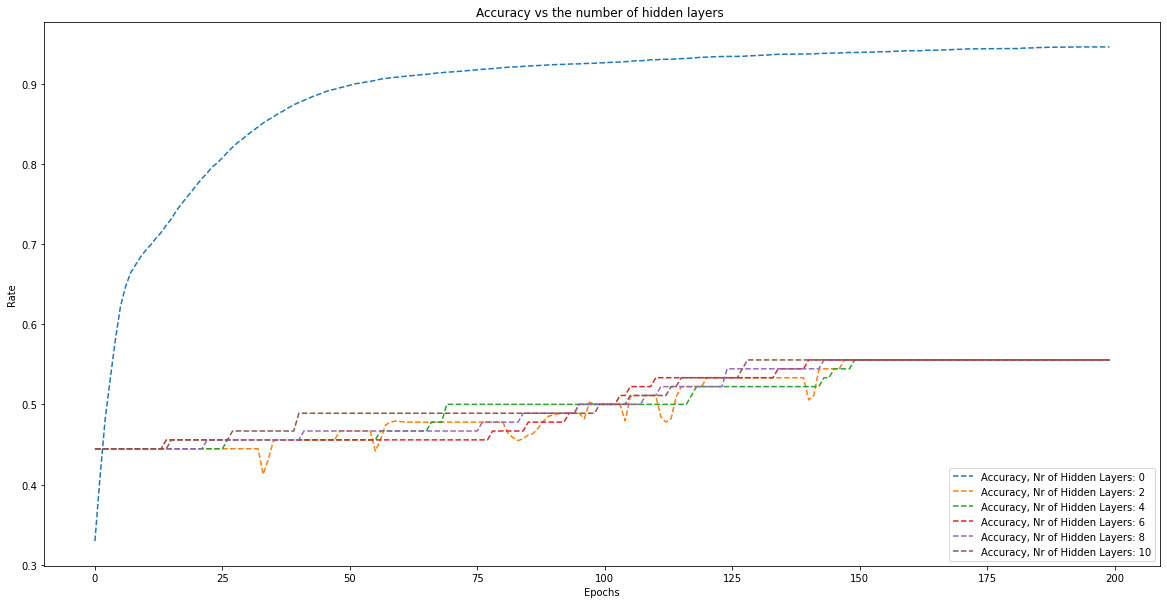

In [6]:
plt.figure(figsize=(20, 10))
for i in range(len(accuracy[0])):
    plt.plot(acc_avg[i], linestyle = 'dashed', label = 'Accuracy, Nr of Hidden Layers: {}'.format(2*i))
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the number of hidden layers ')
plt.legend(loc=4)
plt.show()

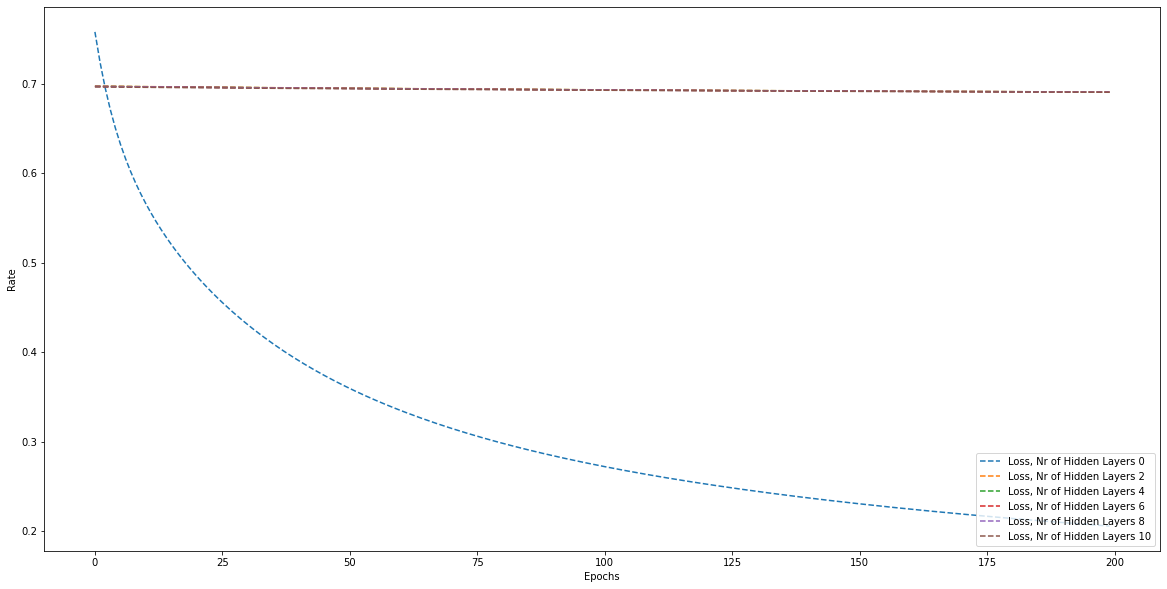

In [7]:
plt.figure(figsize=(20, 10))
for i in range(len(accuracy[0])):   
    plt.plot(loss_avg[i], linestyle = 'dashed', label = 'Loss, Nr of Hidden Layers {}'.format(2*i))
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend(loc=4)
plt.show()

## 2. Number of nodes per layer

Next, investigate the effect of the number of nodes per layer on a network's performance. In the previous experiment networks with 2, 4, and 6 hidden layers performed best (**perhaps this is not the best way to reason about this, the accuracy in the previous section changes dramatically from run to run, as well if the activation is changed**), therefore these architectures will be used as baseline and the number of nodes altered (exclude networks with single node per layer as this scenario was explored in the previous section).  

#### 2.1. Train the model

In [8]:
accuracy_nodes, loss_nodes, t_time_nodes = [], [], []

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (10):
    a_22, l_22, t_22 = train_nn(2, 2, funcs.leaky_relu, 0.01, 200)
    a_23, l_23, t_23 = train_nn(2, 3, funcs.leaky_relu, 0.01, 200)
    a_24, l_24, t_24 = train_nn(2, 4, funcs.leaky_relu, 0.01, 200)
    a_42, l_42, t_42 = train_nn(4, 2, funcs.leaky_relu, 0.01, 200)
    a_43, l_43, t_43 = train_nn(4, 3, funcs.leaky_relu, 0.01, 200)
    a_44, l_44, t_44 = train_nn(4, 4, funcs.leaky_relu, 0.01, 200)
    a_62, l_62, t_62 = train_nn(6, 2, funcs.leaky_relu, 0.01, 200)
    a_63, l_63, t_63 = train_nn(6, 3, funcs.leaky_relu, 0.01, 200)
    a_64, l_64, t_64 = train_nn(6, 4, funcs.leaky_relu, 0.01, 200)
    accuracy_nodes.append([a_22, a_23, a_24, a_42, a_43, a_44, a_62, a_63, a_64])
    loss_nodes.append([l_22, l_23, l_24, l_42, l_43, l_44, l_62, l_63, l_64])
    t_time_nodes.append([t_22, t_23, t_24, t_42, t_43, t_44, t_62, t_63, t_64])

#### 2.2. Find the averages

In [9]:
acc_nodes_avg = np.mean(np.array(accuracy_nodes).T, axis=2).T
loss_nodes_avg = np.mean(np.array(loss_nodes).T, axis=2).T
time_nodes_avg = np.mean(t_time_nodes, axis=0)

#### 2.3. Plot the performance metrics

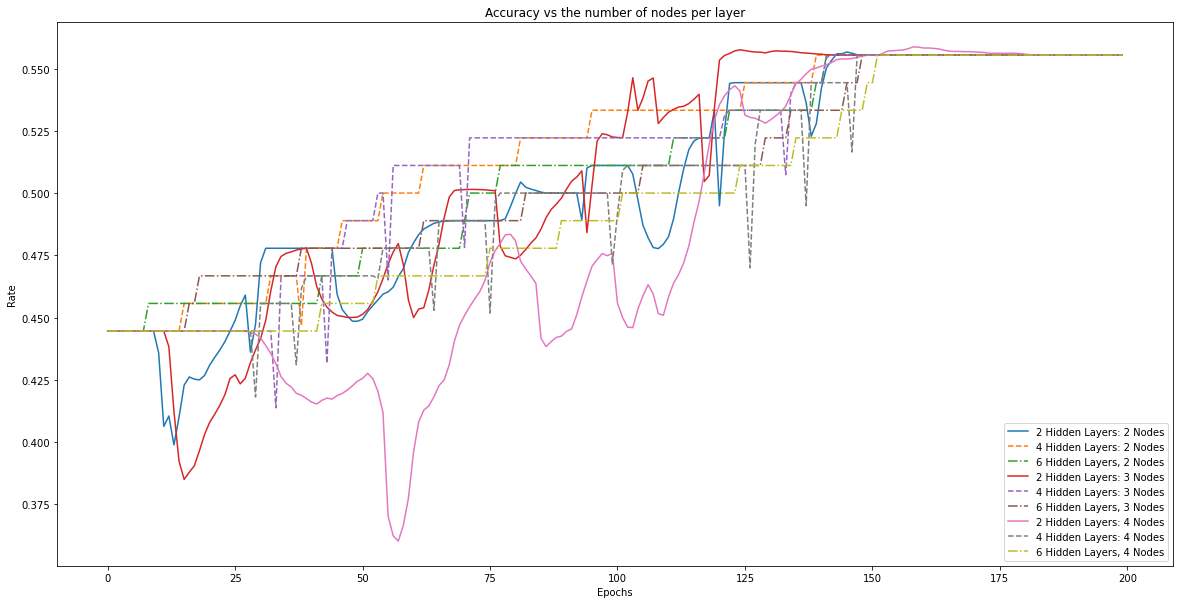

In [10]:
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.plot(acc_nodes_avg[i], linestyle = 'solid', label = '2 Hidden Layers: {} Nodes'.format(i+2))
    plt.plot(acc_nodes_avg[3+i], linestyle = 'dashed', label = '4 Hidden Layers: {} Nodes'.format(i+2))
    plt.plot(acc_nodes_avg[6+i], linestyle = 'dashdot', label = '6 Hidden Layers, {} Nodes'.format(i+2))
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the number of nodes per layer')
plt.legend(loc=4)
plt.show()

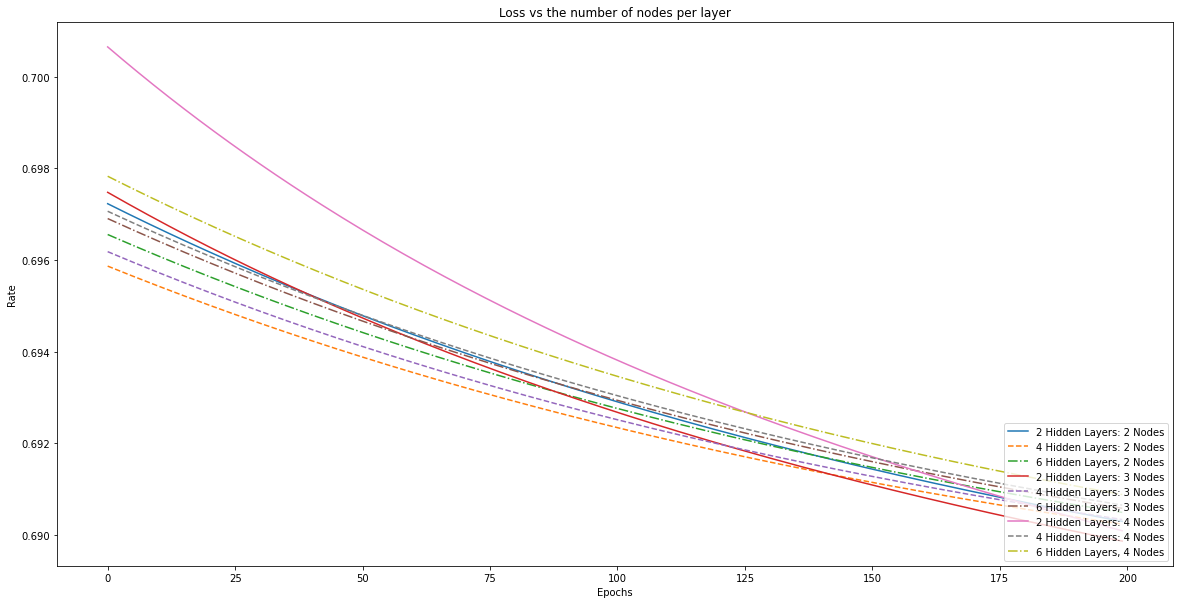

In [11]:
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.plot(loss_nodes_avg[i], linestyle = 'solid', label = '2 Hidden Layers: {} Nodes'.format(i+2))
    plt.plot(loss_nodes_avg[3+i], linestyle = 'dashed', label = '4 Hidden Layers: {} Nodes'.format(i+2))
    plt.plot(loss_nodes_avg[6+i], linestyle = 'dashdot', label = '6 Hidden Layers, {} Nodes'.format(i+2))
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Loss vs the number of nodes per layer')
plt.legend(loc=4)
plt.show()

## 3. Type of activation function

Explore the effect of activation function used in the hidden layers on the model's performance. For the final output to be in the range between 0 and 1 (necessary to evaluate the model's performance using the loss function), sigmoid activation function is used in the output layer.
Activation functions used:
- Logistic activation function (**sigmoid**)
- Hyperbolic tangent activation function (**tanh**)
- Rectified Linear Unit activation function (**relu**)
- Leaky ReLU activation function (**leaky_relu**)

Regardless of the hyper-parameters used, all models in the previous experiments eventually reach the same constant accuracy rate after ~150 epochs, however some combinations of hyper-parameters reach peak accuracy faster than others. Therefore these architecture will be used as baseline to evaluate the effect of activation function in the hidden layers (**not the strongest justification since the best performing architectures change from run to run). <br>
Network architectures used: 
- 6 hidden layers, single node per layer
- 6 hidden layers, 3 nodes per layer (lowest rate of loss)
- 2 hidden layers, 2 nodes per layer 
- 2 hidden layers, 4 nodes per layer

#### 3.1. Train the model

In [12]:
accuracy_func, loss_func, t_time_func = [], [], []

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (10):
    a_61_s, l_61_s, t_61_s = train_nn(6, 1, funcs.sigmoid, 0.01, 200)
    a_61_t, l_61_t, t_61_t = train_nn(6, 1, funcs.tanh, 0.01, 200)
    a_61_r, l_61_r, t_61_r = train_nn(6, 1, funcs.relu, 0.01, 200)
    a_61_lr, l_61_lr, t_61_lr = train_nn(6, 1, funcs.leaky_relu, 0.01, 200)
    a_41_s, l_41_s, t_41_s = train_nn(6, 3, funcs.sigmoid, 0.01, 200)
    a_41_t, l_41_t, t_41_t = train_nn(6, 3, funcs.tanh, 0.01, 200)
    a_41_r, l_41_r, t_41_r = train_nn(6, 3, funcs.relu, 0.01, 200)
    a_41_lr, l_41_lr, t_41_lr = train_nn(6, 3, funcs.leaky_relu, 0.01, 200)
    a_22_s, l_22_s, t_22_s = train_nn(2, 2, funcs.sigmoid, 0.01, 200)
    a_22_t, l_22_t, t_22_t = train_nn(2, 2, funcs.tanh, 0.01, 200)
    a_22_r, l_22_r, t_22_r = train_nn(2, 2, funcs.relu, 0.01, 200)
    a_22_lr, l_22_lr, t_22_lr = train_nn(2, 2, funcs.leaky_relu, 0.01, 200)
    a_24_s, l_24_s, t_24_s = train_nn(2, 4, funcs.sigmoid, 0.01, 200)
    a_24_t, l_24_t, t_24_t = train_nn(2, 4, funcs.tanh, 0.01, 200)
    a_24_r, l_24_r, t_24_r = train_nn(2, 4, funcs.relu, 0.01, 200)
    a_24_lr, l_24_lr, t_24_lr = train_nn(2, 4, funcs.leaky_relu, 0.01, 200)

    accuracy_func.append([a_61_s, a_61_t, a_61_r, a_61_lr, a_41_s, a_41_t, a_41_r, a_41_lr,a_22_s, a_22_t, a_22_r, a_22_lr,a_24_s, a_24_t, a_24_r, a_24_lr])
    loss_func.append([l_61_s, l_61_t, l_61_r, l_61_lr, l_41_s, l_41_t, l_41_r, l_41_lr, l_22_s, l_22_t, l_22_r, l_22_lr, l_24_s, l_24_t, l_24_r, l_24_lr])
    t_time_func.append([t_61_s, t_61_t, t_61_r, t_61_lr, t_41_s, t_41_t, t_41_r, t_41_lr, t_22_s, t_22_t, t_22_r, t_22_lr, t_24_s, t_24_t, t_24_r, t_24_lr])

#### 2.2. Find the averages

In [13]:
acc_func_avg = np.mean(np.array(accuracy_func).T, axis=2).T
loss_func_avg = np.mean(np.array(loss_func).T, axis=2).T
time_func_avg = np.mean(t_time_func, axis=0)

#### 2.3. Plot the performance metrics

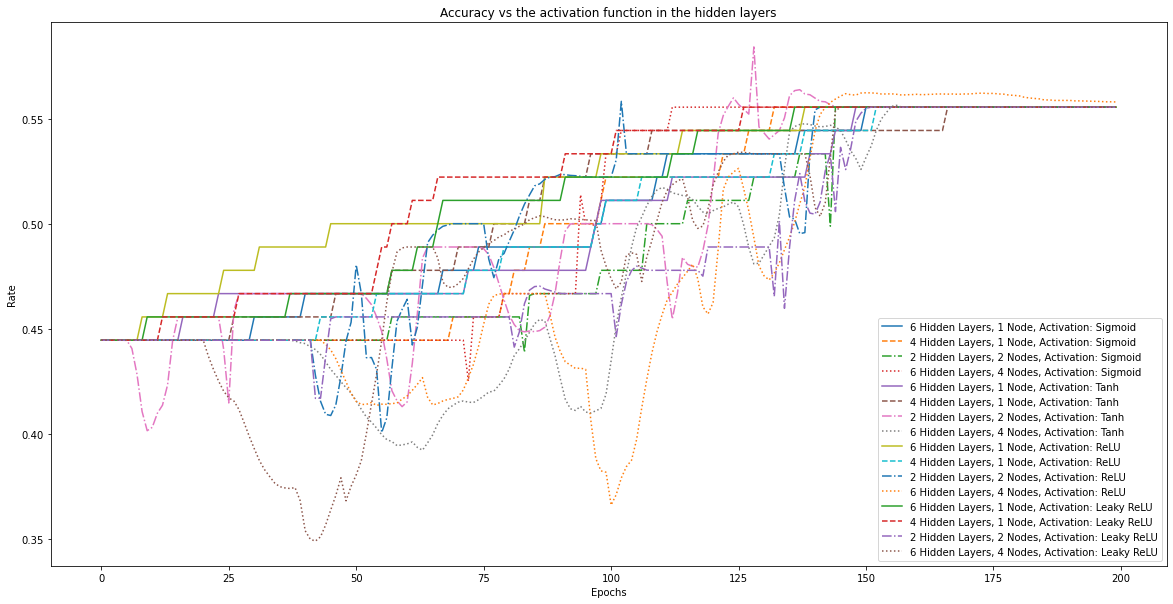

In [14]:
plt.figure(figsize=(20, 10))
activation_funcs = ['Sigmoid', 'Tanh', 'ReLU', 'Leaky ReLU']
for i in range(4):
    plt.plot(acc_func_avg[i], linestyle = 'solid', label = '6 Hidden Layers, 1 Node, Activation: {}'.format(activation_funcs[i]))
    plt.plot(acc_func_avg[4+i], linestyle = 'dashed', label = '4 Hidden Layers, 1 Node, Activation: {}'.format(activation_funcs[i]))
    plt.plot(acc_func_avg[8+i], linestyle = 'dashdot', label = '2 Hidden Layers, 2 Nodes, Activation: {}'.format(activation_funcs[i]))
    plt.plot(acc_func_avg[12+i], linestyle = 'dotted', label = '6 Hidden Layers, 4 Nodes, Activation: {}'.format(activation_funcs[i]))
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the activation function in the hidden layers')
plt.legend(loc=4)
plt.show()

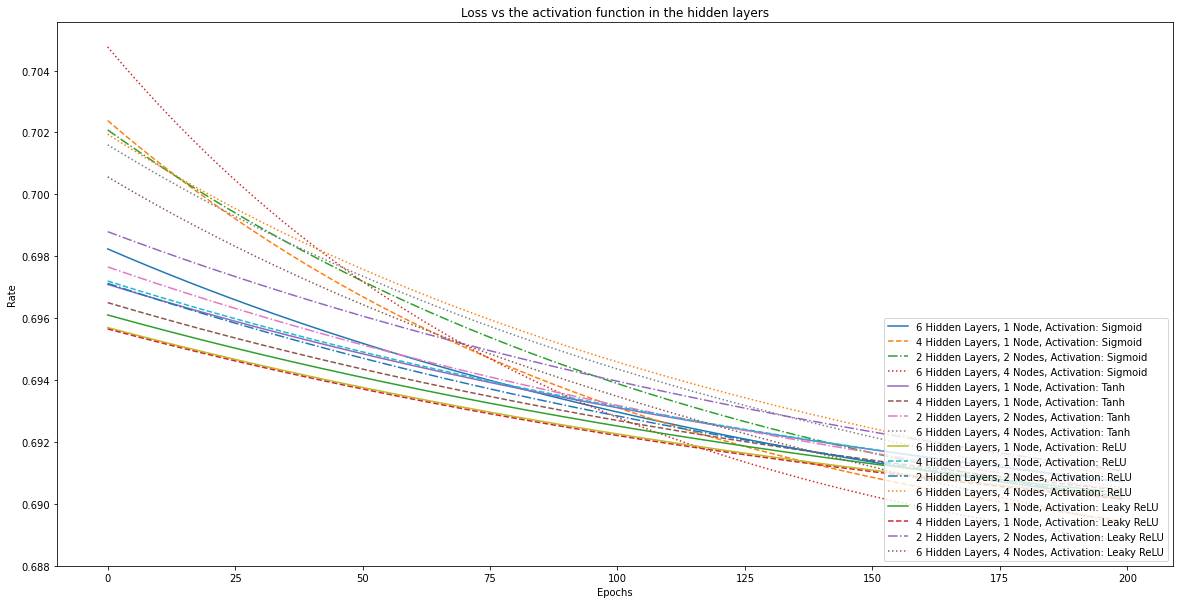

In [15]:
plt.figure(figsize=(20, 10))
for i in range(4):
    plt.plot(loss_func_avg[i], linestyle = 'solid', label = '6 Hidden Layers, 1 Node, Activation: {}'.format(activation_funcs[i]))
    plt.plot(loss_func_avg[4+i], linestyle = 'dashed', label = '4 Hidden Layers, 1 Node, Activation: {}'.format(activation_funcs[i]))
    plt.plot(loss_func_avg[8+i], linestyle = 'dashdot', label = '2 Hidden Layers, 2 Nodes, Activation: {}'.format(activation_funcs[i]))
    plt.plot(loss_func_avg[12+i], linestyle = 'dotted', label = '6 Hidden Layers, 4 Nodes, Activation: {}'.format(activation_funcs[i]))
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Loss vs the activation function in the hidden layers')
plt.legend(loc=4)
plt.show()

## 4. Learning rate 

Baseline architecture of the network used: 2 hidden layers with 2 nodes per layer (**justification?**). <br>
Learning rates tested:
- 0.1
- 0.05
- 0.01
- 0.005
- 0.001

#### 4.1. Train the model

In [16]:
accuracy_alpha, loss_alpha, t_time_alpha = [], [], []

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (10):
    a_22_1, l_22_1, t_22_1 = train_nn(2, 2, funcs.leaky_relu, 0.1, 200)
    a_22_05, l_22_05, t_22_05 = train_nn(2, 2, funcs.leaky_relu, 0.05, 200)
    a_22_01, l_22_01, t_22_01 = train_nn(2, 2, funcs.leaky_relu, 0.01, 200)
    a_22_005, l_22_005, t_22_005 = train_nn(2, 2, funcs.leaky_relu, 0.005, 200)
    a_22_001, l_22_001, t_22_001 = train_nn(2, 2, funcs.leaky_relu, 0.001, 200)

    accuracy_alpha.append([a_22_1, a_22_05, a_22_01, a_22_005, a_22_001])
    loss_alpha.append([l_22_1, l_22_05, l_22_01, l_22_005, l_22_001])
    t_time_alpha.append([t_22_1, t_22_05, t_22_01, t_22_005, t_22_001])

#### 2.2. Find the averages

In [17]:
acc_alpha_avg = np.mean(np.array(accuracy_alpha).T, axis=2).T
loss_alpha_avg = np.mean(np.array(loss_alpha).T, axis=2).T
time_alpha_avg = np.mean(t_time_alpha, axis=0)

#### 2.3. Plot the performance metrics

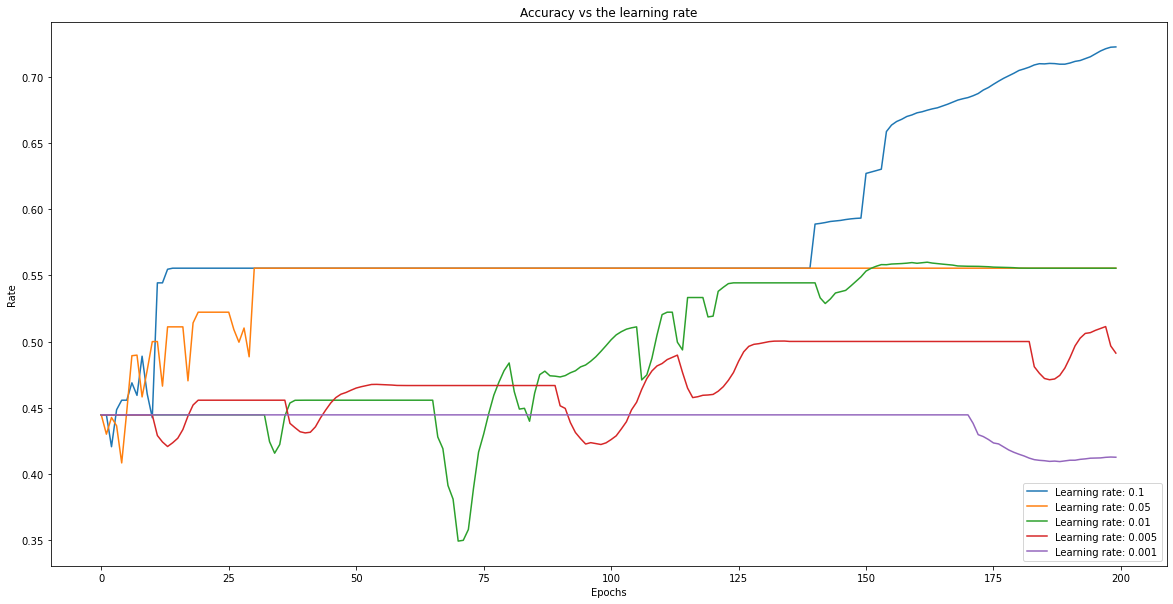

In [18]:
plt.figure(figsize=(20, 10))
learning_rate = ['0.1', '0.05', '0.01', '0.005', '0.001']
for i in range(5):
    plt.plot(acc_alpha_avg[i], linestyle = 'solid', label = 'Learning rate: {}'.format(learning_rate[i]))

    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the learning rate')
plt.legend(loc=4)
plt.show()

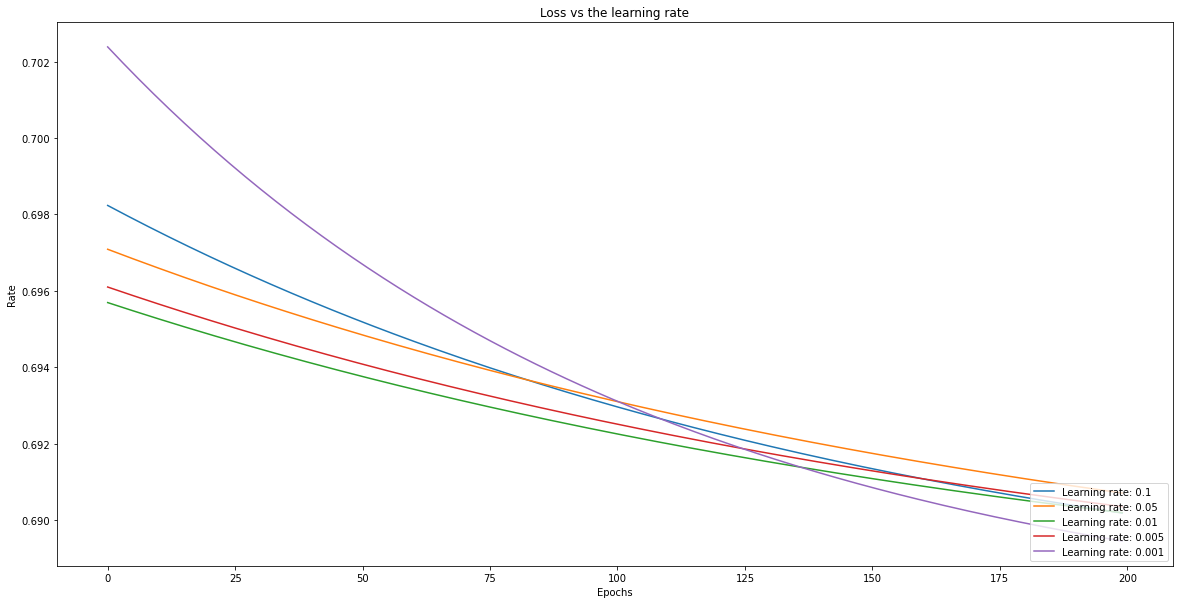

In [19]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.plot(loss_func_avg[i], linestyle = 'solid', label = 'Learning rate: {}'.format(learning_rate[i]))

    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Loss vs the learning rate')
plt.legend(loc=4)
plt.show()

## 5. Number of epochs

Have tried repeated this with all activation functions and increasing number of epochs, same trend.

In [17]:
a, l, t = train_nn(2, 2, funcs.leaky_relu, 0.01, 1000)

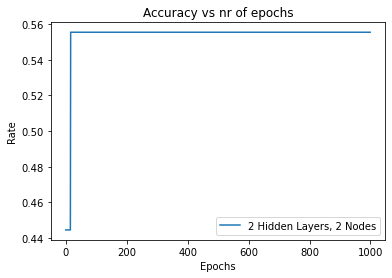

In [18]:
plt.plot(a, linestyle = 'solid', label = '2 Hidden Layers, 2 Nodes')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs nr of epochs')
plt.legend(loc=4)
plt.show()

Just double checking it's not my function messing up the results:

In [15]:
n = net.network(x, [net.layer(2), net.layer(2), net.layer(1)], y, alpha=0.01)
ac, lo = n.learn(1000)

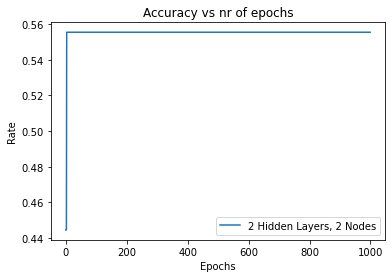

In [16]:
plt.plot(ac, linestyle = 'solid', label = '2 Hidden Layers, 2 Nodes')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs nr of epochs')
plt.legend(loc=4)
plt.show()